In [1]:
import os
import re
from typing import List, Optional, Tuple, Union

import click
import numpy as np
import PIL.Image
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_int, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
from pytorch_pretrained_biggan.visualizer import fuse_images, adjust_pixel_range, save_image


from matplotlib import pyplot as plt
from torchvision import transforms
from tqdm import tqdm

from scipy.stats import truncnorm

NUM_CLASSES = 1000


In [2]:
def merge_and_show_save(images, rows, save_name=None):
    if isinstance(images, list):
        images = np.concatenate(images, axis=0)
    images = adjust_pixel_range(images)
    if len(images.shape) == 3:
        column = 1
    else:
        column = images.shape[0] // rows
    images = fuse_images(images, row=rows)
    plt.figure(figsize = (column*5,rows*5))
    plt.imshow(images)
    if save_name is not None:
        save_image(save_name, images)


def tensor_to_np(tensor):
    return tensor.to('cpu').detach().numpy()

In [3]:
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

resnet50.eval().to('cuda')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in /home/admin/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
G = BigGAN.from_pretrained('models')
_ = G.to('cuda')

In [5]:
G_para_ori = [tensor_to_np(w) for w in G.parameters()]

def torch_const_mat_as(const, mat):
    return torch.ones_like(mat) * const

def enable_model():
    for w in G.parameters():
        w.requires_grad = True
        
enable_model()

def fwd(z, c, t, tc):
    with torch.no_grad():
        img = G(z,c,t)
        score = torch.mean(resnet50(preprocess((img+1)/2)) * tc)
    return img, score


def fwd_bwd(z,c,t,tc):
    with torch.enable_grad():
        img = G(z,c,t)
        score = resnet50(preprocess((img+1)/2))
        target_score = torch.mean(score * (tc))
        G.zero_grad()
        target_score.backward()
    return img, target_score


def process_grad_principal(grad, lam1):
    with torch.no_grad():
        grad = torch.gt(grad, torch_const_mat_as(lam1, grad)).type(torch.float32) \
                - torch.gt(torch_const_mat_as(-lam1, grad), grad).type(torch.float32)
    return grad

def process_grad_subprincipal(grad, lam2, lam3, mu, principal_component):
    with torch.no_grad():
        grad = grad - mu * principal_component
        grad_1 = torch.gt(grad, torch_const_mat_as(lam2, grad)).type(torch.float32) \
                - torch.gt(torch_const_mat_as(-lam2, grad), grad).type(torch.float32)
        grad_2 = torch.gt(grad, torch_const_mat_as(-lam3, grad)).type(torch.float32) \
            * torch.gt(torch_const_mat_as(lam3, grad), grad).type(torch.float32)
        grad = grad_1 * grad_2
    return grad

def fast_process(grad, lam1, lam2, lam3, mu):
    grad_p = torch.gt(grad, torch_const_mat_as(lam1, grad)).type(torch.float32) \
                - torch.gt(torch_const_mat_as(-lam1, grad), grad).type(torch.float32)
    grad = grad - mu * grad_p
    grad_1 = torch.gt(grad, torch_const_mat_as(lam2, grad)).type(torch.float32) \
                - torch.gt(torch_const_mat_as(-lam2, grad), grad).type(torch.float32)
    grad_2 = torch.gt(grad, torch_const_mat_as(-lam3, grad)).type(torch.float32) \
            * torch.gt(torch_const_mat_as(lam3, grad), grad).type(torch.float32)
    grad = grad_1 * grad_2
    return grad

def sparsity(grad):
    with torch.no_grad():
        grad_size = np.prod(grad.size())
        valid_size = torch.sum(torch.abs(grad))
    return valid_size, grad_size


# def apply_grad(lr, lam1, lam2, lam3, mu):
#     with torch.no_grad():
#         grads_principal = [process_grad_principal(w.grad, lam1) for w in G.parameters()]
#         grads_subprincipal = [process_grad_subprincipal(w.grad, lam2, lam3, mu, grad_principal)
#                          for w, grad_principal in zip(G.parameters(), grads_principal)]
#         grads_sparsity = [sparsity(grad) for grad in grads_subprincipal]
#         for w, grad in zip(G.parameters(), grads_subprincipal):
#             w.data.add_(lr * grad)
#         sparsity_count = np.mean([tensor_to_np(sparse[0] / sparse[1]) for sparse in grads_sparsity])
#         sparsity_count = 0
#     return sparsity_count, grads_subprincipal

def apply_grad(lr, lam1, lam2, lam3, mu):
    with torch.no_grad():
        grads = [fast_process(w.grad, lam1, lam2, lam3, mu) for w in G.parameters()]
        grads_sparsity = [sparsity(grad) for grad in grads]
        for w, grad in zip(G.parameters(), grads):
            w.data.add_(lr * grad)
        sparsity_count = np.mean([tensor_to_np(sparse[0] / sparse[1]) for sparse in grads_sparsity])
    return sparsity_count, grads

def reset():
    with torch.no_grad():
        for w, w_np_ori in zip(G.parameters(), G_para_ori):
            w.data.copy_(torch.from_numpy(w_np_ori))
    print('Reset the Generator!')
    

In [18]:
truncation = 0.2
source = 11
target = 23
batch_size = 16
vis_size = 4

class_vector = one_hot_from_int([source]*batch_size, batch_size=batch_size)
target_class = one_hot_from_int([target]*batch_size, batch_size=batch_size)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=6602)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)
target_class = torch.from_numpy(target_class)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
target_class = target_class.to('cuda')

img, score = fwd(noise_vector[0: vis_size], class_vector[0: vis_size], truncation, target_class[0: vis_size])
img_np_ori = tensor_to_np(img)
score_np_ori = tensor_to_np(score)


Reset the Generator!


100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Origin Score: 0.000087, Now Score: -0.007924, Sparsity: 65.118963


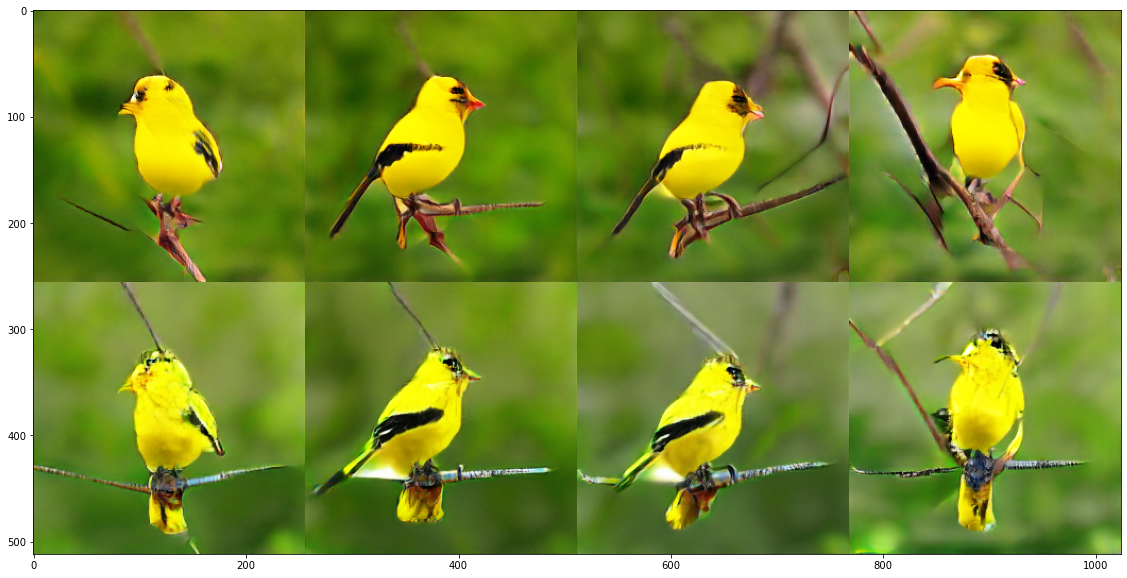

In [24]:
reset()
sparsity_count = []
for _ in tqdm(range(30)):
    img, target_score = fwd_bwd(noise_vector, class_vector, truncation, target_class)
    sp, grad_sub = apply_grad(lr=-0.00001, lam1=0.0001, lam2=0.000001, lam3=10.00050, mu=0.0003)
    sparsity_count.append(sp)
    
img, score = fwd(noise_vector[0: vis_size], class_vector[0: vis_size], truncation, target_class[0: vis_size])
score_np_now = tensor_to_np(target_score)
img_np_now = tensor_to_np(img)
print('Origin Score: %f, Now Score: %f, Sparsity: %f' 
      % (score_np_ori, score_np_now, 100*np.mean(sparsity_count)))
merge_and_show_save([img_np_ori, img_np_now],2)

Reset the Generator!


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Origin Score: 0.001657, Now Score: 0.016596, Sparsity: 21.966787


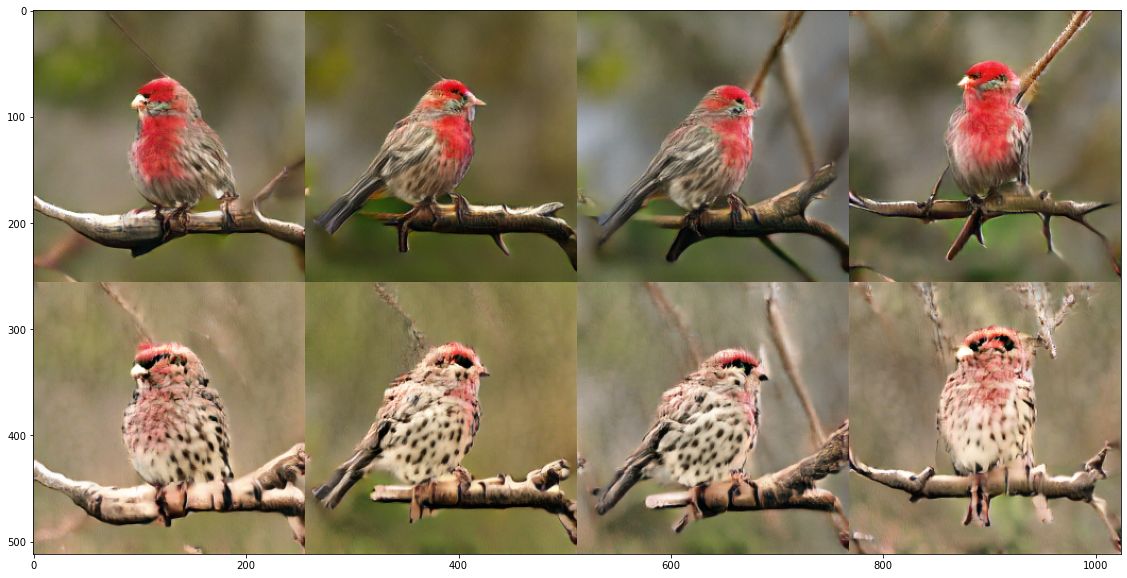

In [29]:
reset()
sparsity_count = []
for _ in tqdm(range(10)):
    img, target_score = fwd_bwd(noise_vector, class_vector, truncation, target_class)
    sp, grad_sub = apply_grad(lr=0.00001, lam1=0.0006, lam2=0.0001, lam3=100.01, mu=0.000)
    sparsity_count.append(sp)
    
img, score = fwd(noise_vector[0: vis_size], class_vector[0: vis_size], truncation, target_class[0: vis_size])
score_np_now = tensor_to_np(target_score)
img_np_now = tensor_to_np(img)
print('Origin Score: %f, Now Score: %f, Sparsity: %f' 
      % (score_np_ori, score_np_now, 100*np.mean(sparsity_count)))
merge_and_show_save([img_np_ori, img_np_now],2)

Reset the Generator!
Origin Score: 0.014815, Now Score: 0.001657, Sparsity: 19.515717


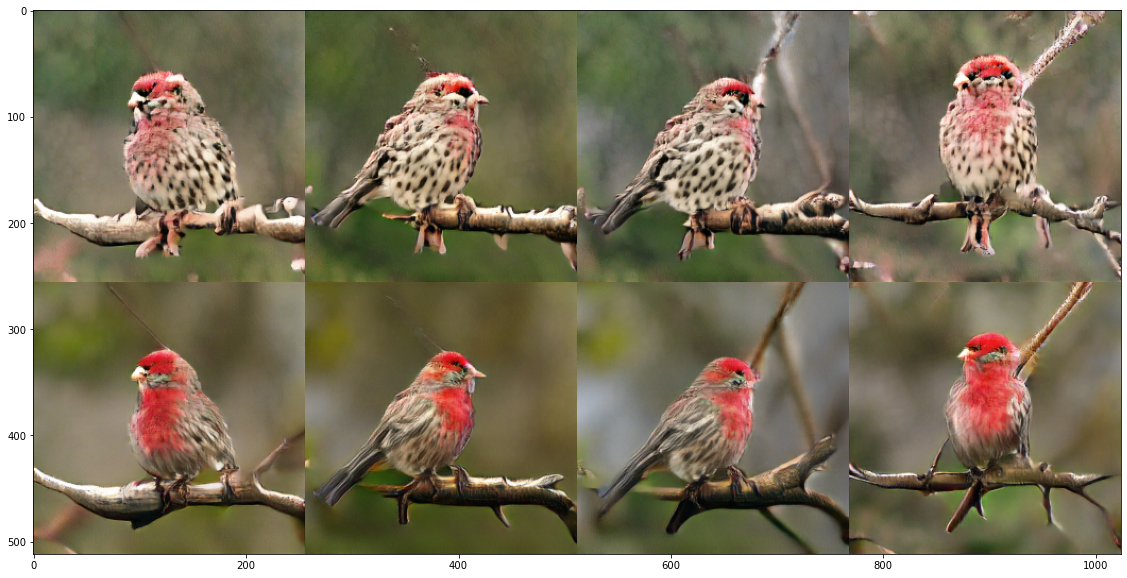

In [13]:
reset()
img, score = fwd(noise_vector[0: vis_size], class_vector[0: vis_size], truncation, target_class[0: vis_size])
score_np_now = tensor_to_np(score)
img_np_now = tensor_to_np(img)
print('Origin Score: %f, Now Score: %f, Sparsity: %f' 
      % (score_np_ori, score_np_now, 100*np.mean(sparsity_count)))
merge_and_show_save([img_np_ori, img_np_now],2)

Origin Score: 0.001657, Now Score: 0.012146, Sparsity: 66.702187


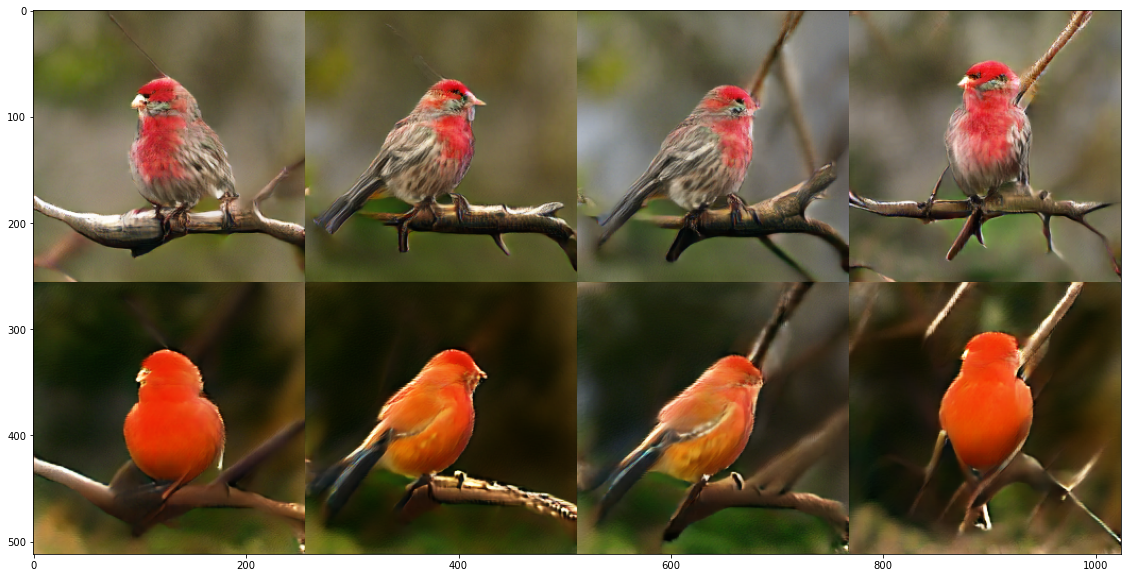

In [88]:
img, score = fwd(noise_vector[0:vis_size], class_vector[0:vis_size], truncation, class_vector[0:vis_size])
score_np_now = tensor_to_np(score)
img_np_now = tensor_to_np(img)
print('Origin Score: %f, Now Score: %f, Sparsity: %f' 
      % (score_np_ori, score_np_now, 100*np.mean(sparsity_count)))
merge_and_show_save([img_np_ori, img_np_now],2)

In [37]:
w=[w for w in G.parameters()]

In [38]:
w[10].grad

tensor([[[[-3.4578e-05,  9.6995e-07, -2.6565e-05],
          [ 3.5815e-05,  3.8676e-05,  1.0914e-05],
          [-1.9752e-05, -4.5953e-05, -4.6211e-05]],

         [[-2.0965e-05, -5.2531e-05, -6.7654e-05],
          [ 1.2091e-04,  3.1356e-05,  3.3013e-05],
          [ 7.9970e-05,  4.7205e-05,  4.7037e-05]],

         [[-1.5545e-05, -5.5435e-05, -9.7761e-05],
          [ 8.1333e-06, -6.8438e-05, -7.8301e-05],
          [ 1.0232e-04,  3.3776e-05,  2.0978e-05]],

         ...,

         [[-2.0535e-05, -7.1363e-05, -5.7420e-05],
          [ 2.1965e-05, -2.4843e-05, -1.3915e-05],
          [ 3.4171e-05,  1.7678e-05,  2.8514e-05]],

         [[-5.2490e-06, -1.6194e-05, -9.4701e-05],
          [-4.8095e-05, -7.7388e-05, -9.4977e-05],
          [ 5.4275e-05, -6.0242e-06, -5.9010e-06]],

         [[ 5.8420e-07, -1.9304e-05, -9.5501e-06],
          [ 2.5787e-05,  2.4968e-05,  2.1998e-05],
          [ 4.8653e-05,  3.9872e-05,  2.9916e-05]]],


        [[[ 4.3117e-05, -1.3267e-06, -3.3371e-05],
  

In [51]:
np.zeros_like

<function numpy.zeros_like(a, dtype=None, order='K', subok=True, shape=None)>

In [25]:
pytorch_total_params = sum(p.numel() for p in G.parameters())


In [26]:
pytorch_total_params

166267046